# Importing Libraries

In [1]:
import psycopg2
from psycopg2 import OperationalError
import csv
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

## Uploading the Data

In [2]:
df_answer_content=pd.read_csv('answer_content.csv')

In [3]:
df_article_and_answer_info=pd.read_csv('article_and_answer_info.csv')
df_article_content=pd.read_csv('article_content.csv')
df_questions=pd.read_csv('questions.csv')
df_timeline=pd.read_csv('timeline.csv')
df_topic_tree=pd.read_csv('topic_tree.csv')
df_user_info=pd.read_csv('user_info.csv')

C:\Users\fariz\AppData\Local\Temp\ipykernel_23388\1351524476.py:1: DtypeWarning: Columns (3,10,11,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df_article_and_answer_info=pd.read_csv('article_and_answer_info.csv')
C:\Users\fariz\AppData\Local\Temp\ipykernel_23388\1351524476.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_questions=pd.read_csv('questions.csv')


### Data Cleaning

In [4]:
## converting timeline into 2014-07-24 04:04:16 yyyy-mm-dd hh:mm:ss
df_timeline['created_time']=pd.to_datetime(df_timeline['created_time'],unit='s')

##### Choosing the relevant columns
- Population based on **X. Han, Y. Li and T. Wang** paper, we construct the active influencers, which actively posted article 
- Filtering the influencers which still active and posted article or answers. The badge is divided into three category, both badges, best-answerer, and self identity.
- Gap on papers:
    - it is said that it only cover the relatinship of the number of vote on the number of answers. the on this section, it covers the direct effect of how votes directly affect answers without intermediate steps. Then, indirect effect, one of the formula counted votes lead to increasing number of answers.
    - It may be that the number of votes will increase the number of answer, but does the number of votes (viral) will increase the number of productivity ?
    - it was identify the other causal inference but did not separate the difference effect between the contents

In [5]:
# Selecting the relevant columns based on literature review
df_article_and_answer_info=df_article_and_answer_info[['id','type','userId','voteupCount','commentCount','answerType']]
df_article_content
df_user_info=df_user_info[['id', 'name', 'gender', 'badgeType', 'badgeDescription','followerCount','followingCount']]
df_timeline=df_timeline[['id', 'user_id', 'target_id', 'target_type', 'verb', 'action_text','created_time']]

In [6]:
## Filling Badges new with the additional dataset
file_path = 'time_invariant_control_full_sample.pkl'
data = pd.read_pickle(file_path)

In [7]:
# merging user_info with new dataset to fill the null value on badges
merged_df = pd.merge(df_user_info, data, left_on='id', right_on='user_id', how='left', suffixes=('', '_new'))

# Refill the 'badgeType' column based on the conditions
def determine_badge(row):
    if row['identity_badge'] == 1 and row['best_answerer_badge'] == 0:
        return 'identity'
    elif row['best_answerer_badge'] == 1 and row['identity_badge'] == 0:
        return 'best_answerer'
    else:
        return 'both badges'
    return row['badgeType']

merged_df['badgeType'] = merged_df.apply(determine_badge, axis=1)

# Drop the redundant new columns
merged_df = merged_df.drop(columns=[col for col in merged_df.columns if col.endswith('_new') or col in ['identity_badge', 'best_answerer_badge']])

### Descriptive Statisics

#### Article and answer info descriptive statistics

In [8]:
print(df_article_and_answer_info.info())
df_article_and_answer_info.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2735035 entries, 0 to 2735034
Data columns (total 6 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   id            int64 
 1   type          object
 2   userId        object
 3   voteupCount   int64 
 4   commentCount  int64 
 5   answerType    object
dtypes: int64(3), object(3)
memory usage: 125.2+ MB
None


,id,voteupCount,commentCount
count,2.735035e+06,2.735035e+06,2.735035e+06
mean,1.392597e+09,1.178040e+03,1.016215e+02
std,9.837581e+08,4.987114e+03,3.707023e+02
min,1.220201e+07,0.000000e+00,0.000000e+00
25%,4.906019e+08,1.800000e+01,2.000000e+00
50%,1.285185e+09,8.500000e+01,1.300000e+01
75%,2.312342e+09,5.160000e+02,6.800000e+01
max,3.155393e+09,6.337590e+05,1.271270e+05


In [9]:
df_article_and_answer_info.isnull().sum()

id                   0
type                 0
userId               6
voteupCount          0
commentCount         0
answerType      458352
dtype: int64

#### Descriptive Statistics Article Content

In [10]:
print(df_article_content.info())
df_article_content.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458687 entries, 0 to 458686
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       458687 non-null  int64 
 1   content  458686 non-null  object
dtypes: int64(1), object(1)
memory usage: 7.0+ MB
None


,id
count,4.586870e+05
mean,2.545499e+08
std,2.075159e+08
min,1.955450e+07
25%,6.322008e+07
50%,1.513971e+08
75%,4.340485e+08
max,6.485584e+08


In [11]:
df_article_content.isna().sum()

id         0
content    1
dtype: int64

#### Descriptive Statistics User Info

In [12]:
merged_df=merged_df[['id', 'name', 'gender', 'badgeType', 'badgeDescription','followerCount', 'followingCount']]

In [13]:
print(merged_df.info())
merged_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2296 entries, 0 to 2295
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                2296 non-null   object
 1   name              2296 non-null   object
 2   gender            2296 non-null   int64 
 3   badgeType         2296 non-null   object
 4   badgeDescription  1514 non-null   object
 5   followerCount     2296 non-null   int64 
 6   followingCount    2296 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 125.7+ KB
None


,gender,followerCount,followingCount
count,2296.000000,2.296000e+03,2296.000000
mean,0.674652,1.528452e+05,404.914199
std,0.613559,2.367946e+05,640.996425
min,-1.000000,0.000000e+00,0.000000
25%,1.000000,4.050450e+04,93.000000
50%,1.000000,8.349850e+04,229.500000
75%,1.000000,1.691505e+05,498.250000
max,1.000000,3.466603e+06,11692.000000


In [14]:
merged_df.isna().sum()

id                    0
name                  0
gender                0
badgeType             0
badgeDescription    782
followerCount         0
followingCount        0
dtype: int64

#### Descriptive Statistics Timeline

In [15]:
print(df_timeline.info())
df_timeline.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6251237 entries, 0 to 6251236
Data columns (total 7 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   user_id       object        
 2   target_id     int64         
 3   target_type   object        
 4   verb          object        
 5   action_text   object        
 6   created_time  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 333.9+ MB
None


,id,target_id,created_time
count,6.251237e+06,6.251237e+06,6251237
mean,1.607185e+12,1.337539e+17,2020-12-05 16:09:43.099497472
min,1.406175e+12,2.019000e+03,2014-07-24 04:04:16
25%,1.568347e+12,4.573251e+08,2019-09-13 03:52:38
50%,1.608534e+12,1.291147e+09,2020-12-21 06:53:27
75%,1.649077e+12,2.481494e+09,2022-04-04 12:57:35
max,1.691386e+12,1.671605e+18,2023-08-07 05:27:06
std,4.864612e+10,4.000716e+17,NaN


In [16]:
df_timeline.isna().sum()

id                   0
user_id              0
target_id            0
target_type          0
verb            568320
action_text          0
created_time         0
dtype: int64

#### Data Distributions Check

#### Quantitative Columns

In [17]:
Quantitative_columns=['voteupCount', 'commentCount', 'followerCount', 'followingCount']

C:\Users\fariz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\fariz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


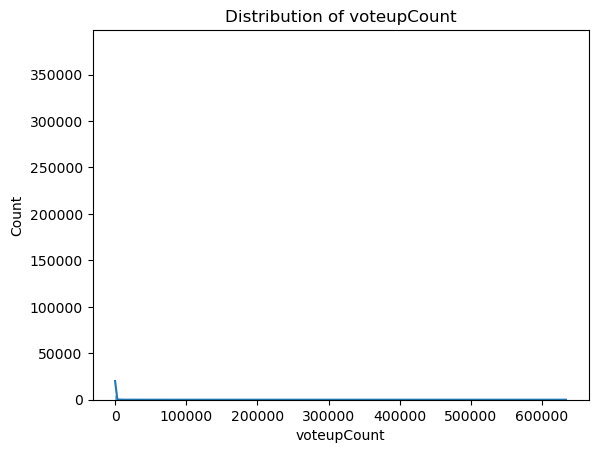

C:\Users\fariz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\fariz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


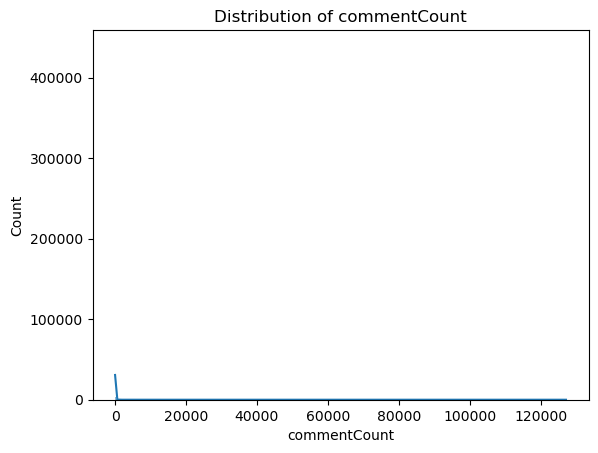

C:\Users\fariz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\fariz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


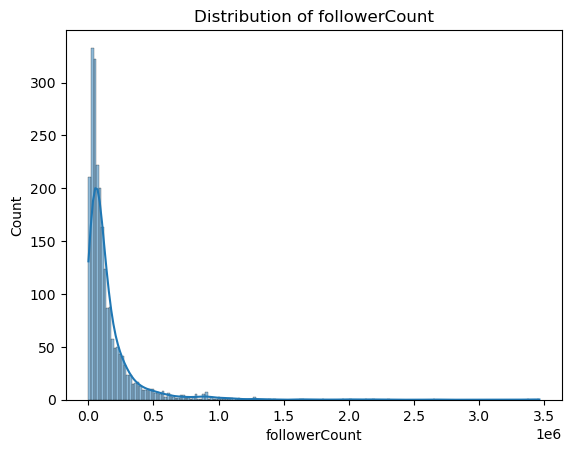

C:\Users\fariz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\fariz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


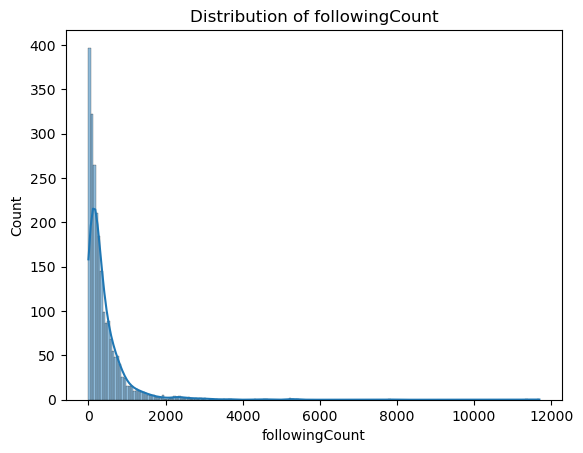

In [18]:
for col in Quantitative_columns:
    if col in df_article_and_answer_info:
        sns.histplot(df_article_and_answer_info[col], kde=True)
        plt.title(f'Distribution of {col}')
        plt.show()
    elif col in merged_df:
        sns.histplot(merged_df[col], kde=True)
        plt.title(f'Distribution of {col}')
        plt.show()

#### Categorical Columns

In [19]:
print(df_article_and_answer_info['type'].value_counts())

type
answer     2276539
article     458496
Name: count, dtype: int64


In [20]:
print(df_article_and_answer_info['answerType'].value_counts())

answerType
normal    2271216
paid         5467
Name: count, dtype: int64


In [21]:
print(merged_df['badgeType'].value_counts())

badgeType
both badges      1407
best_answerer     888
identity            1
Name: count, dtype: int64


#### Normalize the Data Distribution of Quantitative Columns

CLT will be working to the means of samples, hence, we have to transform it from the individual data points to the samples means

In [22]:
##### Transformation
df_article_and_answer_info['log_voteupCount'] = np.log1p(df_article_and_answer_info['voteupCount'])
df_article_and_answer_info['log_commentCount'] = np.log1p(df_article_and_answer_info['commentCount'])
merged_df['log_followerCount'] = np.log1p(merged_df['followerCount'])
merged_df['log_followingCount'] = np.log1p(merged_df['followingCount'])

C:\Users\fariz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\fariz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


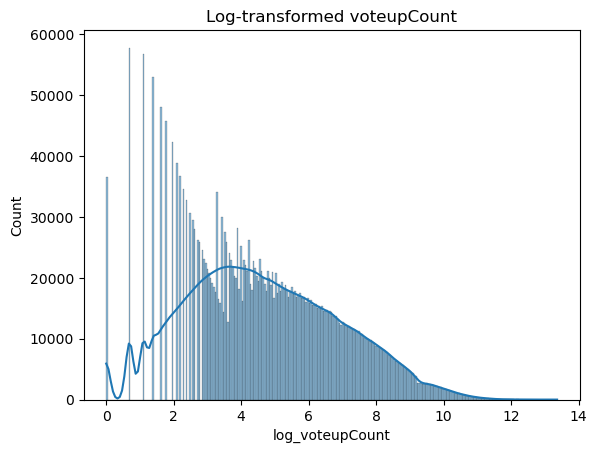

In [23]:
sns.histplot(df_article_and_answer_info['log_voteupCount'],kde=True)
plt.title('Log-transformed voteupCount')
plt.show()

C:\Users\fariz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\fariz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


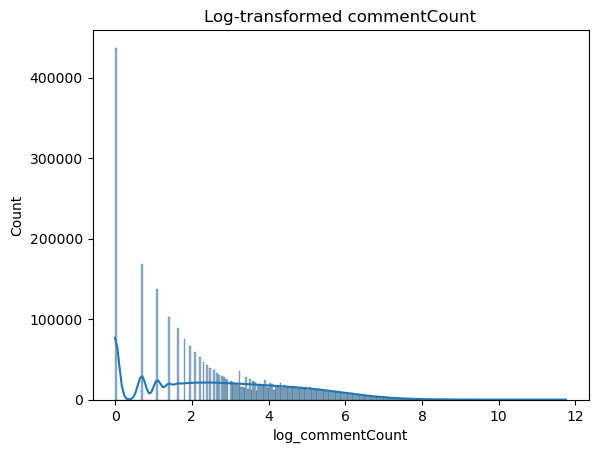

In [24]:
sns.histplot(df_article_and_answer_info['log_commentCount'],kde=True)
plt.title('Log-transformed commentCount')
plt.show()

C:\Users\fariz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\fariz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


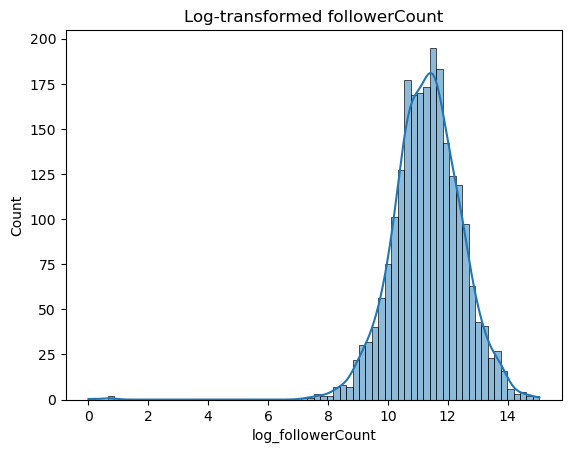

In [25]:
sns.histplot(merged_df['log_followerCount'],kde=True)
plt.title('Log-transformed followerCount')
plt.show()

C:\Users\fariz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\fariz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


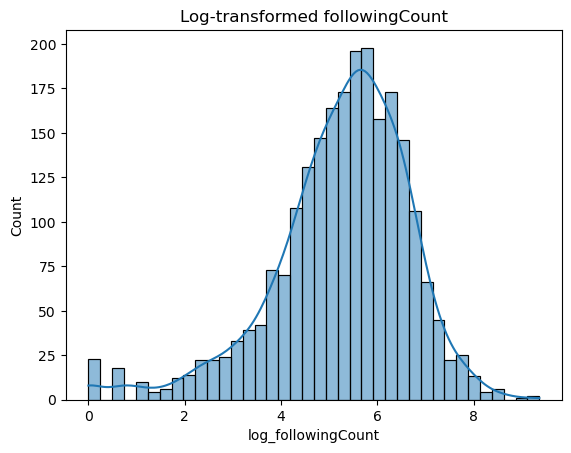

In [26]:
sns.histplot(merged_df['log_followingCount'],kde=True)
plt.title('Log-transformed followingCount')
plt.show()

#### Normalize the Data Distribution of Qualitative Columns

the problem that arises from the qualitative columns is the imbalance proportion between two group.**However** , based on my hypotheses and research questions I developed, it is acceptable to have an imbalanced qualitative distribution because our focuses on identifying different badges, different content, and get the result from the differences.

# Merging the tables needed

In [27]:
## Checking how many influencers that get viral answers or articles within 10 years
merged_df_article_content=pd.merge(df_article_content,df_article_and_answer_info,on='id')
print(merged_df_article_content.shape)

(458685, 9)


In [28]:
merged_article_timelines=pd.merge(merged_df_article_content,df_timeline, left_on='id',right_on='target_id', how='inner')
merged_article_timelines.shape

(760398, 16)

In [29]:
merged_df.columns

Index(['id', 'name', 'gender', 'badgeType', 'badgeDescription',
       'followerCount', 'followingCount', 'log_followerCount',
       'log_followingCount'],
      dtype='object')

In [30]:
merged_article_timelines=merged_article_timelines[['id_x', 'content', 'type', 'userId', 'voteupCount','commentCount','log_voteupCount','log_commentCount', 'created_time']]
#merged_article_timelines=merged_article_timelines[['id_x', 'content', 'type', 'userId', 'voteupCount','commentCount', 'created_time']]

In [31]:
merged_article_timelines.rename(columns={'id_x':'id'},inplace=True)

In [32]:
result_df = pd.merge(merged_df, merged_article_timelines, left_on='id', right_on='userId',how='inner')
result_df.shape

(390173, 18)

In [33]:
result_df.rename(columns={'id_x':'id'},inplace=True)

In [34]:
result_df.head()

,id,name,gender,badgeType,badgeDescription,followerCount,followingCount,log_followerCount,log_followingCount,id_y,content,type,userId,voteupCount,commentCount,log_voteupCount,log_commentCount,created_time
0,5b4c4c40369aa3294b09f8e4bd715f23,megadrive2,1,both badges,NaN,2188905,249,14.598912,5.521461,19580471,"<p data-pid=""Tgmqs63t"">貌似各行各业都有一些外人看来难到匪夷所思的专门...",article,5b4c4c40369aa3294b09f8e4bd715f23,430,78,6.066108,4.369448,2021-02-08 12:40:21
1,5b4c4c40369aa3294b09f8e4bd715f23,megadrive2,1,both badges,NaN,2188905,249,14.598912,5.521461,19589083,"<p data-pid=""7VSZYvUW"">原载于[《二次元狂热》第18期 2010年4月...",article,5b4c4c40369aa3294b09f8e4bd715f23,312,43,5.746203,3.784190,2019-05-09 02:50:54
2,5b4c4c40369aa3294b09f8e4bd715f23,megadrive2,1,both badges,NaN,2188905,249,14.598912,5.521461,19665604,"<p data-pid=""NUNBKvaT"">这是从回答的问题转过来的，因为我提到ATARI...",article,5b4c4c40369aa3294b09f8e4bd715f23,330,63,5.802118,4.158883,2018-02-08 14:54:21
3,5b4c4c40369aa3294b09f8e4bd715f23,megadrive2,1,both badges,NaN,2188905,249,14.598912,5.521461,19687058,"<p data-pid=""Wh8RYbYk"">来自本题答案</p><p data-pid=""...",article,5b4c4c40369aa3294b09f8e4bd715f23,803,134,6.689599,4.905275,2019-10-13 17:22:08
4,5b4c4c40369aa3294b09f8e4bd715f23,megadrive2,1,both badges,NaN,2188905,249,14.598912,5.521461,19687058,"<p data-pid=""Wh8RYbYk"">来自本题答案</p><p data-pid=""...",article,5b4c4c40369aa3294b09f8e4bd715f23,803,134,6.689599,4.905275,2020-11-30 05:52:00
